In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: C:\Users\02485986\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1. Library & Data Import

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [3]:
# Data import
df = pd.read_csv('TSLA.csv') 
df_copy = df.copy()

In [4]:
# Overall data info
df_copy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [5]:
df_copy.shape

(2956, 7)

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [7]:
# The Date column is converted to a datetime object

df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.sort_values('Date', inplace=True)

## 2. Target Creation

In [8]:
# Target variable is the daily percentage change in the closing price of the Tesla stock

df_copy['Daily_Close_Change'] = (df_copy['Close'] - df_copy['Close'].shift(1))/df_copy['Close'].shift(1)

### 2.1 Target threshold = 5%

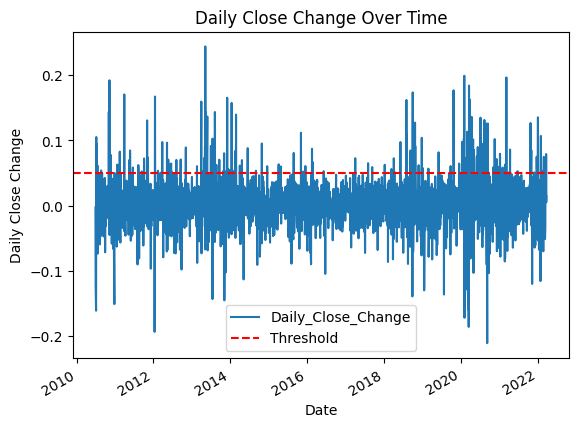

In [9]:
# Graphical respresentation of target variable for threshold selection

df_copy.plot(x='Date', y='Daily_Close_Change')

# Adding a horizontal line at y = 0.05
plt.axhline(y=0.05, color='r', linestyle='--', label='Threshold')
plt.title('Daily Close Change Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Close Change')
plt.legend()
plt.show()

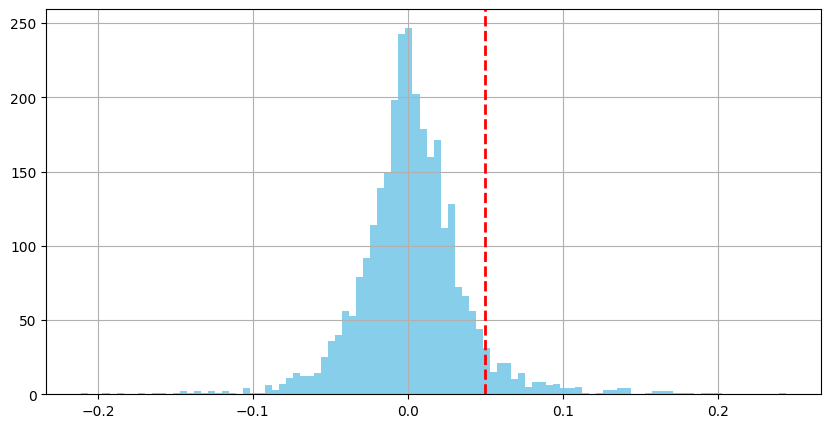

In [10]:
# Analysis of the distribution of target variable when the threshold is set at 0.05

df_copy['Daily_Close_Change'].hist(bins=100,figsize = (10,5),color = 'skyblue').axvline(0.05,color ='r',linestyle ='dashed',linewidth=2)

In [11]:
# The distribution of target value is unbalanced but random data elimination is risky for time series.
# We should eliminate the data based on time or change the threshold value.

df_copy['Target'] = np.where(df_copy['Daily_Close_Change'] >= 0.05, 1, 0)

df_copy['Target'].value_counts()

0    2782
1     174
Name: Target, dtype: int64

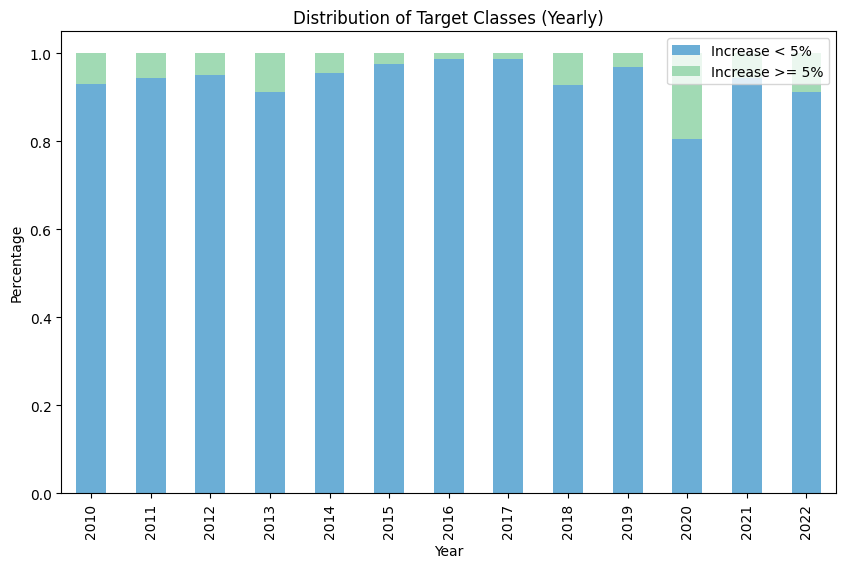

In [12]:
# The target classes distribution is not unbalanced between years. So, eliminating data based on years is not a solution.

df_copy['Year'] = df_copy['Date'].dt.year
colors = ['#6baed6', '#a1dab4']

yearly_target_perc = df_copy.groupby('Year')['Target'].value_counts(normalize=True).unstack().fillna(0)
yearly_target_perc.plot(kind='bar', stacked=True, figsize=(10, 6),color=colors)
plt.title('Distribution of Target Classes (Yearly)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(['Increase < 5%', 'Increase >= 5%'], loc='upper right')
plt.show()

In [13]:
def calculate_target_percentages(df, target_column):
    value_counts = df[target_column].value_counts()
    total = df[target_column].count()
    percentages = value_counts / total * 100
    return percentages

In [14]:
def calculate_target_percentages_iteratively(df, target_column, step=100):
    i = 0
    while i < len(df):
        percentages = calculate_target_percentages(df[i:], target_column)
        print(f"After eliminating first {i} rows:")
        print(percentages)
        print("\n")
        i += step

In [15]:
# Even if we limit the data to the last 100 rows, the target distribution is still unbalanced because we didn't shuffle the data.

calculate_target_percentages_iteratively(df_copy, 'Target')

After eliminating first 0 rows:
0    94.113667
1     5.886333
Name: Target, dtype: float64


After eliminating first 100 rows:
0    94.187675
1     5.812325
Name: Target, dtype: float64


After eliminating first 200 rows:
0    94.1582
1     5.8418
Name: Target, dtype: float64


After eliminating first 300 rows:
0    94.126506
1     5.873494
Name: Target, dtype: float64


After eliminating first 400 rows:
0    94.131455
1     5.868545
Name: Target, dtype: float64


After eliminating first 500 rows:
0    94.218241
1     5.781759
Name: Target, dtype: float64


After eliminating first 600 rows:
0    94.10017
1     5.89983
Name: Target, dtype: float64


After eliminating first 700 rows:
0    93.927305
1     6.072695
Name: Target, dtype: float64


After eliminating first 800 rows:
0    94.248609
1     5.751391
Name: Target, dtype: float64


After eliminating first 900 rows:
0    94.357977
1     5.642023
Name: Target, dtype: float64


After eliminating first 1000 rows:
0    94.427403
1     5.

### 2.2. Target threshold = 1%

In [16]:
# We will determine the target again, but this time we will decrease the threshold.
# Third quartile of the target variable is 0.01. We can use this value as a threshold since we couldn't find a balance with iterative elimination.

df_copy['Daily_Close_Change'].describe() 

count    2955.000000
mean        0.002444
std         0.035600
min        -0.210628
25%        -0.015090
50%         0.001258
75%         0.019249
max         0.243951
Name: Daily_Close_Change, dtype: float64

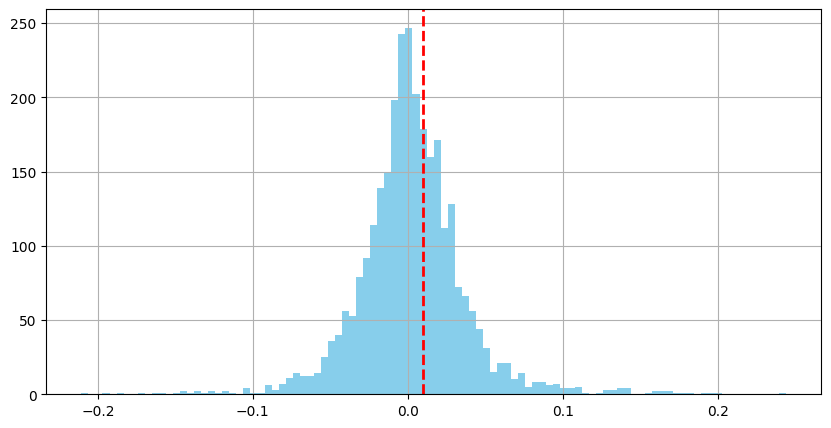

In [17]:
df_copy['Daily_Close_Change'].hist(bins=100,figsize = (10,5),color = 'skyblue').axvline(0.01,color ='r',linestyle ='dashed',linewidth=2)

In [18]:
df_copy['Target'] = np.where(df_copy['Daily_Close_Change'] >= 0.01, 1, 0)
df_copy['Target'].value_counts()

0    1883
1    1073
Name: Target, dtype: int64

### 2.3. Target Decision

- Lowering the target threshold resulted in more balanced data. However, business requirements may not always align with data challenges. Therefore, we aim to predict a 5% change in the Tesla stock closing prices within a single day.

- The target classses will be balanced with the class weight parameter in the models.

In [19]:
df_copy['Target'] = np.where(df_copy['Daily_Close_Change'] >= 0.05, 1, 0)
df_copy['Target'].value_counts()

0    2782
1     174
Name: Target, dtype: int64

In [20]:
df_copy.drop(columns=['Daily_Close_Change'], inplace=True)

## 3. Feature Creation

### 3.1. Exponential Moving Average

In [21]:
def Exponential_Moving_Average(data,columns_to_process,window_sizes):
    
    epsilon = 1e-8

    for col in columns_to_process:
        for window in window_sizes:

            # EMA Percentage --> Weights more to the current records
            ema_col_name = f'{col}_EMA_{window}_Percentage'
            ema = data[col].ewm(span=window, adjust=False).mean() + epsilon
            data[ema_col_name] = (data[col] - ema) / data[col]
    
    return data

columns_to_process = ['Open', 'High', 'Low', 'Adj Close']
window_sizes = [7, 15, 21, 30]

df_with_ema = Exponential_Moving_Average(df_copy,columns_to_process,window_sizes)

In [22]:
df_with_ema.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Year,Open_EMA_7_Percentage,...,High_EMA_21_Percentage,High_EMA_30_Percentage,Low_EMA_7_Percentage,Low_EMA_15_Percentage,Low_EMA_21_Percentage,Low_EMA_30_Percentage,Adj Close_EMA_7_Percentage,Adj Close_EMA_15_Percentage,Adj Close_EMA_21_Percentage,Adj Close_EMA_30_Percentage
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,0,2010,-2.631579e-09,...,-2.000000e-09,-2.000000e-09,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0,2010,1.974603e-01,...,1.619748e-01,1.666773e-01,1.854077e-01,2.163090e-01,2.247366e-01,2.312612e-01,-1.888378e-03,-2.203107e-03,-2.288943e-03,-2.355396e-03
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0,2010,1.290750e-01,...,1.498571e-02,2.058362e-02,4.773063e-02,8.676615e-02,9.895338e-02,1.088423e-01,-6.540301e-02,-7.660235e-02,-7.967153e-02,-8.205204e-02
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,0,2010,4.000679e-02,...,-9.569344e-02,-9.259559e-02,-2.375067e-02,9.294826e-03,2.166003e-02,3.231109e-02,-1.639160e-01,-2.024434e-01,-2.135221e-01,-2.222682e-01
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,0,2010,-7.799414e-02,...,-2.413872e-01,-2.450480e-01,-1.575036e-01,-1.495788e-01,-1.421203e-01,-1.344697e-01,-2.903719e-01,-3.789447e-01,-4.057121e-01,-4.272420e-01


### 3.2. Stochastic Oscillators

In [23]:
def Stochastic_Oscillator_Feature(data,column_of_low_value,column_of_high_value):

    lowest_5 = data[column_of_low_value].rolling(window = 5).min()
    highest_5 = data[column_of_high_value].rolling(window = 5).max()

    data['Stochastic_5'] = ((data['Close'] - lowest_5)/(highest_5 - lowest_5))*100

    lowest_15 = data[column_of_low_value].rolling(window = 15).min()
    highest_15 = data[column_of_high_value].rolling(window = 15).max()

    data['Stochastic_15'] = ((data['Close'] - lowest_15)/(highest_15 - lowest_15))*100

    return(data)

In [24]:
df_stochastic = Stochastic_Oscillator_Feature(df_with_ema,'Low','High')

In [25]:
df_stochastic.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Year,Open_EMA_7_Percentage,...,Low_EMA_7_Percentage,Low_EMA_15_Percentage,Low_EMA_21_Percentage,Low_EMA_30_Percentage,Adj Close_EMA_7_Percentage,Adj Close_EMA_15_Percentage,Adj Close_EMA_21_Percentage,Adj Close_EMA_30_Percentage,Stochastic_5,Stochastic_15
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,0,2010,-2.631579e-09,...,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0,2010,1.974603e-01,...,1.854077e-01,2.163090e-01,2.247366e-01,2.312612e-01,-1.888378e-03,-2.203107e-03,-2.288943e-03,-2.355396e-03,NaN,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0,2010,1.290750e-01,...,4.773063e-02,8.676615e-02,9.895338e-02,1.088423e-01,-6.540301e-02,-7.660235e-02,-7.967153e-02,-8.205204e-02,NaN,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,0,2010,4.000679e-02,...,-2.375067e-02,9.294826e-03,2.166003e-02,3.231109e-02,-1.639160e-01,-2.024434e-01,-2.135221e-01,-2.222682e-01,NaN,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,0,2010,-7.799414e-02,...,-1.575036e-01,-1.495788e-01,-1.421203e-01,-1.344697e-01,-2.903719e-01,-3.789447e-01,-4.057121e-01,-4.272420e-01,1.919123,NaN


### 3.3. Relative Strength Index (RSI)

In [26]:
def Relative_Strength_Index(data):
    
    data['Diff'] = data['Close'].diff()
    data['Up'] = data['Diff']
    data.loc[(data['Up']<0), 'Up'] = 0
    
    data['Down'] = data['Diff']
    data.loc[(data['Down']>0), 'Down'] = 0 
    data['Down'] = abs(data['Down'])

    data['Up_5MA'] = data['Up'].rolling(window=5).mean()
    data['Down_5MA'] = data['Down'].rolling(window=5).mean()

    data['Up_15MA'] = data['Up'].rolling(window=15).mean()
    data['Down_15MA'] = data['Down'].rolling(window=15).mean()

    data['RS_5'] = data['Up_5MA'] / data['Down_5MA']
    data['RS_15'] = data['Up_15MA'] / data['Down_15MA']

    data['RSI_5'] = 100 - (100/(1+data['RS_5']))
    data['RSI_15'] = 100 - (100/(1+data['RS_15']))

    data['RSI_ratio'] = data['RSI_5']/data['RSI_15']

    # Drop the columns that are not used to create a feature and may result multicollinearity in the future 

    data.drop(columns = ['Diff','Up','Down','Up_5MA','Down_5MA','Up_15MA','Down_15MA','RS_5','RS_15','RSI_5','RSI_15'], inplace=True)

    return data

In [27]:
df_relative = Relative_Strength_Index(df_stochastic)

In [28]:
df_relative.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Year,Open_EMA_7_Percentage,...,Low_EMA_15_Percentage,Low_EMA_21_Percentage,Low_EMA_30_Percentage,Adj Close_EMA_7_Percentage,Adj Close_EMA_15_Percentage,Adj Close_EMA_21_Percentage,Adj Close_EMA_30_Percentage,Stochastic_5,Stochastic_15,RSI_ratio
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,0,2010,-2.631579e-09,...,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,NaN,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0,2010,1.974603e-01,...,2.163090e-01,2.247366e-01,2.312612e-01,-1.888378e-03,-2.203107e-03,-2.288943e-03,-2.355396e-03,NaN,NaN,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0,2010,1.290750e-01,...,8.676615e-02,9.895338e-02,1.088423e-01,-6.540301e-02,-7.660235e-02,-7.967153e-02,-8.205204e-02,NaN,NaN,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,0,2010,4.000679e-02,...,9.294826e-03,2.166003e-02,3.231109e-02,-1.639160e-01,-2.024434e-01,-2.135221e-01,-2.222682e-01,NaN,NaN,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,0,2010,-7.799414e-02,...,-1.495788e-01,-1.421203e-01,-1.344697e-01,-2.903719e-01,-3.789447e-01,-4.057121e-01,-4.272420e-01,1.919123,NaN,NaN


# 4. Exploratory Data Analysis

In [29]:
df_copy.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Year,Open_EMA_7_Percentage,...,Low_EMA_15_Percentage,Low_EMA_21_Percentage,Low_EMA_30_Percentage,Adj Close_EMA_7_Percentage,Adj Close_EMA_15_Percentage,Adj Close_EMA_21_Percentage,Adj Close_EMA_30_Percentage,Stochastic_5,Stochastic_15,RSI_ratio
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,0,2010,-2.631579e-09,...,-2.850627e-09,-2.850627e-09,-2.850627e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,-2.092926e-09,NaN,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0,2010,1.974603e-01,...,2.163090e-01,2.247366e-01,2.312612e-01,-1.888378e-03,-2.203107e-03,-2.288943e-03,-2.355396e-03,NaN,NaN,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0,2010,1.290750e-01,...,8.676615e-02,9.895338e-02,1.088423e-01,-6.540301e-02,-7.660235e-02,-7.967153e-02,-8.205204e-02,NaN,NaN,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,0,2010,4.000679e-02,...,9.294826e-03,2.166003e-02,3.231109e-02,-1.639160e-01,-2.024434e-01,-2.135221e-01,-2.222682e-01,NaN,NaN,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,0,2010,-7.799414e-02,...,-1.495788e-01,-1.421203e-01,-1.344697e-01,-2.903719e-01,-3.789447e-01,-4.057121e-01,-4.272420e-01,1.919123,NaN,NaN


In [30]:
df_copy.shape

(2956, 28)

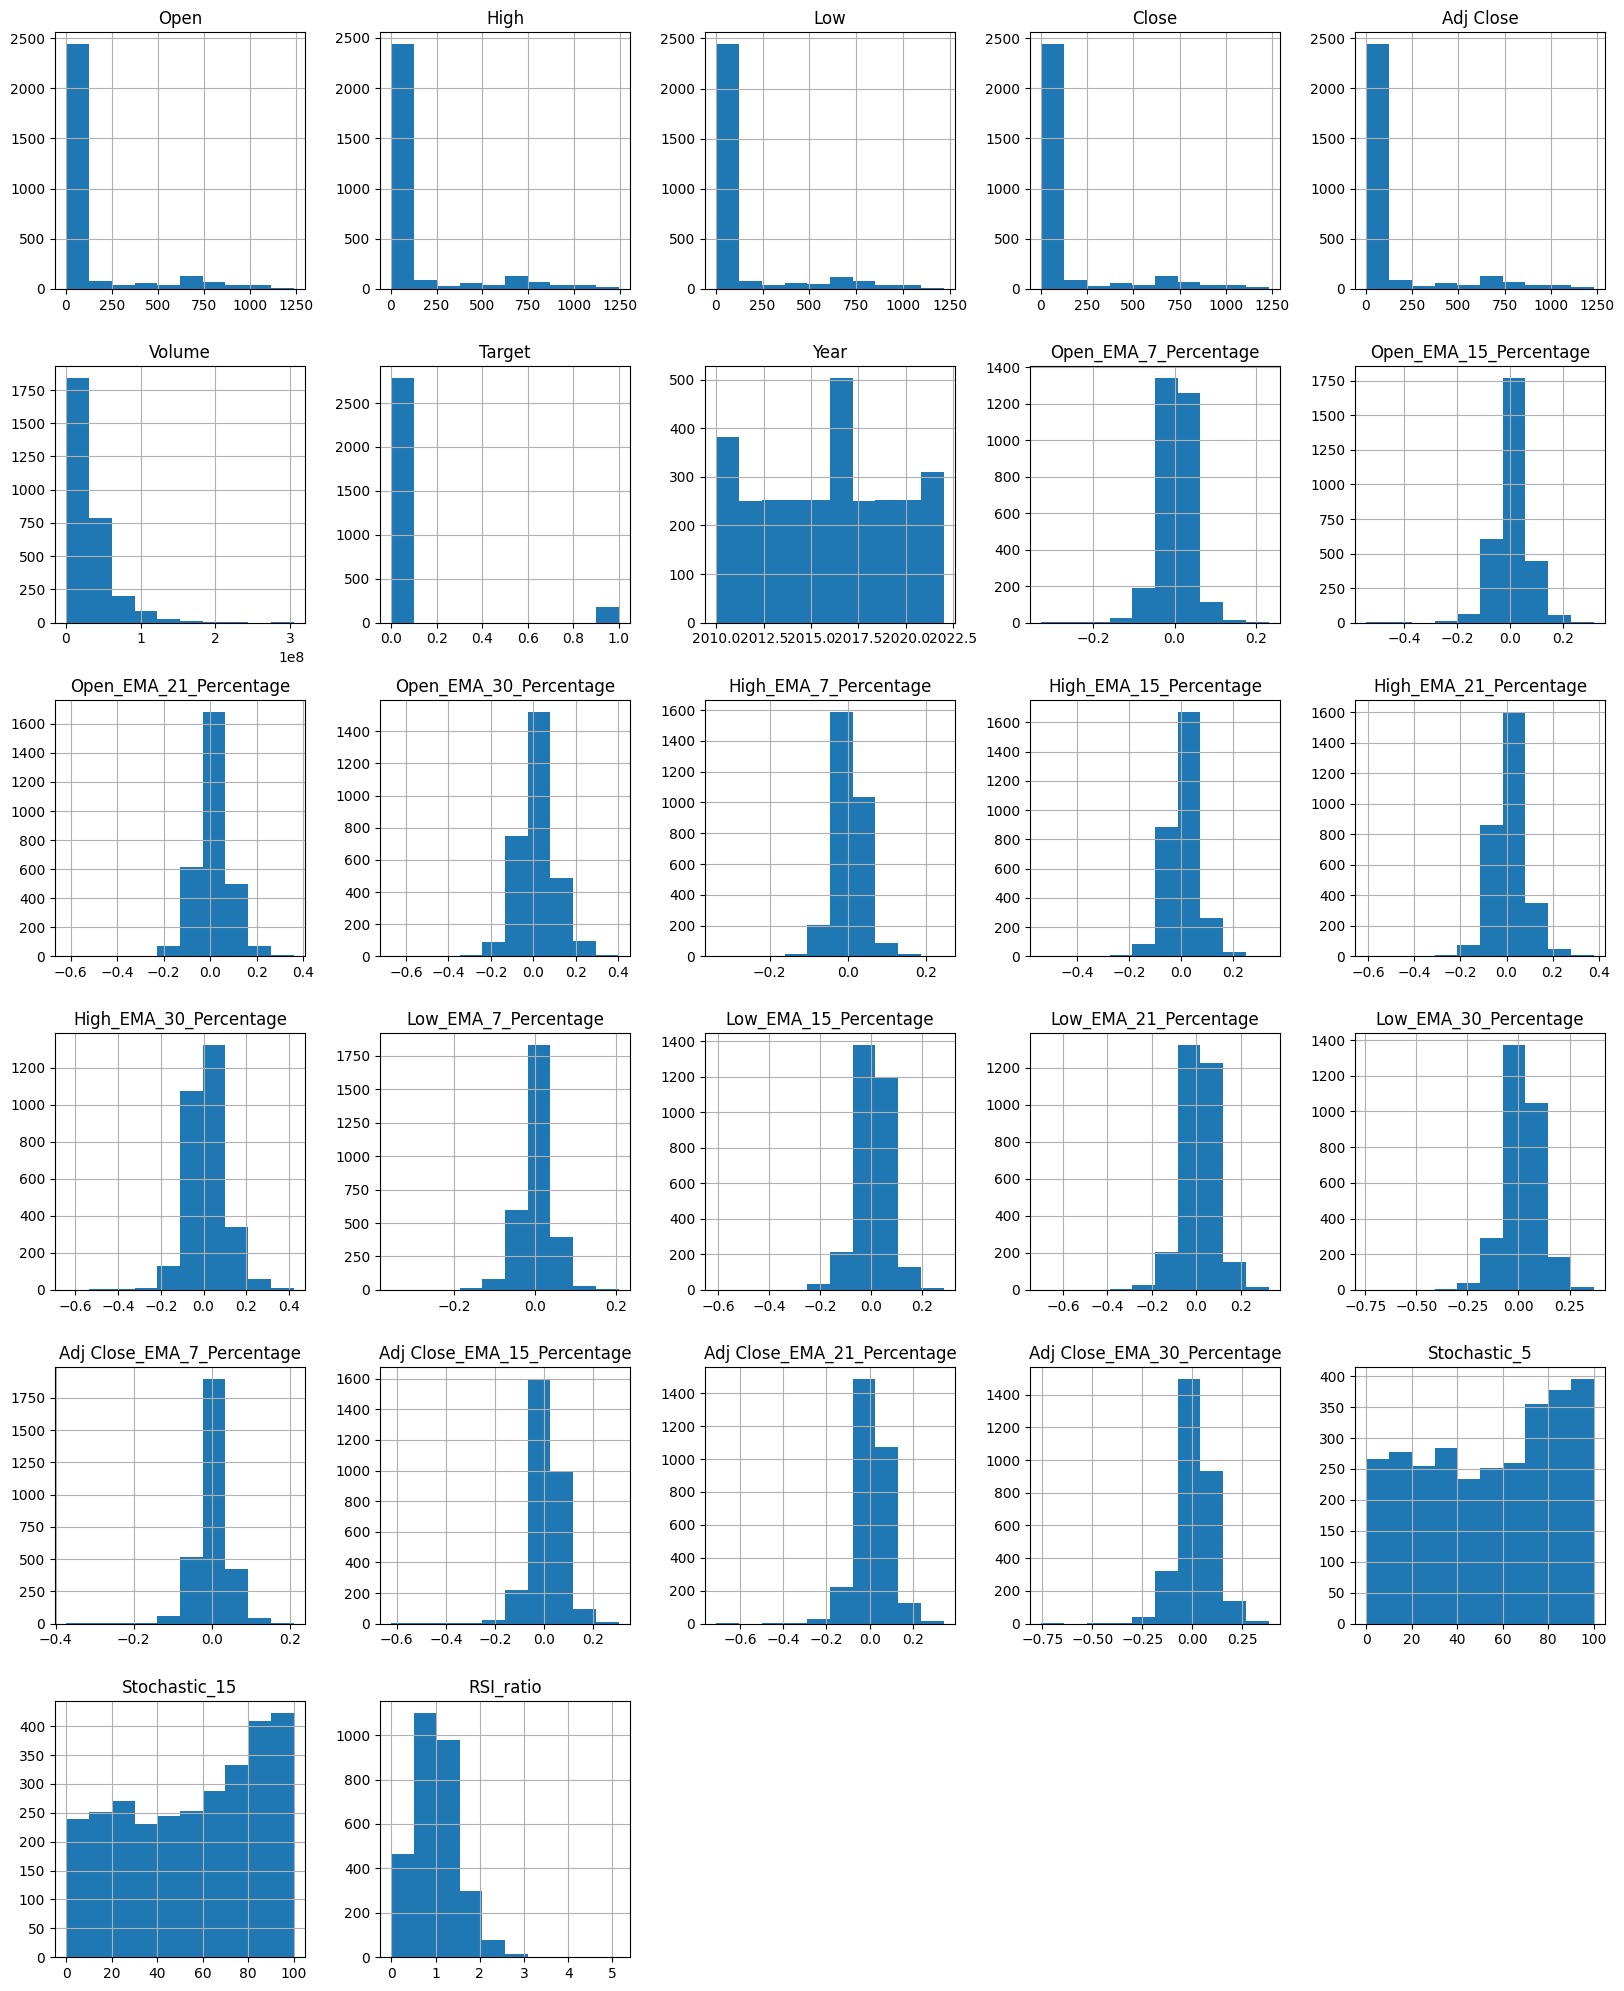

In [31]:
df_numeric = df_copy.drop(columns=['Date'],axis=1)
df_numeric.hist(figsize=(20,25))
plt.show()

In [32]:
def table_intro(df):
    
    dtypes = df.dtypes
    dtypes_df = pd.DataFrame({'variable':dtypes.index, 'var_type':dtypes.values}).set_index('variable')
    unq = df.nunique()
    unq_df = pd.DataFrame({'variable':unq.index, 'unique_count':unq.values}).set_index('variable')
    cnt = df.count()
    cnt_df = pd.DataFrame({'variable':cnt.index, 'count':cnt.values}).set_index('variable')
    cnt_null = df.isnull().sum()
    cnt_null_df = pd.DataFrame({'variable':cnt_null.index, 'null_count':cnt_null.values}).set_index('variable')
    summary_df = dtypes_df.join(unq_df).join(cnt_df).join(cnt_null_df)
    summary_df['is_unique'] = summary_df.apply(lambda x: 1 if x['unique_count']==x['count'] else 0, axis = 1)
    summary_df['null_ratio'] = summary_df.apply(lambda x: format(x['null_count']*100/(x['null_count']+x['count']),".2f"), axis = 1) 

    return(summary_df)

In [33]:
table_intro(df_copy)

,var_type,unique_count,count,null_count,is_unique,null_ratio
variable,,,,,,
Date,datetime64[ns],2956,2956,0,1,0.00
Open,float64,2666,2956,0,0,0.00
High,float64,2662,2956,0,0,0.00
Low,float64,2672,2956,0,0,0.00
Close,float64,2764,2956,0,0,0.00
Adj Close,float64,2764,2956,0,0,0.00
Volume,int64,2925,2956,0,0,0.00
Target,int32,2,2956,0,0,0.00
Year,int64,13,2956,0,0,0.00


### 4.1. Missing Values

In [34]:
# Replace infinite values with a large finite value
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filled = df_copy.bfill().ffill()

In [35]:
if df_filled.isnull().any().any() == True:
    print('There are still missing values in the dataset')
else:
    print('There are no missing values in the dataset')

There are no missing values in the dataset


In [36]:
# Since we created features from the same columns, we can drop the original columns
df_filled.drop(columns = ['Open','High','Low','Close','Adj Close','Volume','Stochastic_5','Year'],inplace=True)

### 4.2. Correlation Analysis

- Heatmap shows the correlation between the features and the target.
- We can see that the features are not highly correlated with the target.
- We can also see that some features are highly correlated with each other.
- We can eliminate one of the highly correlated features to prevent multicollinearity.

C:\Users\02485986\AppData\Local\Temp\ipykernel_47444\3669734174.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_filled.corr()


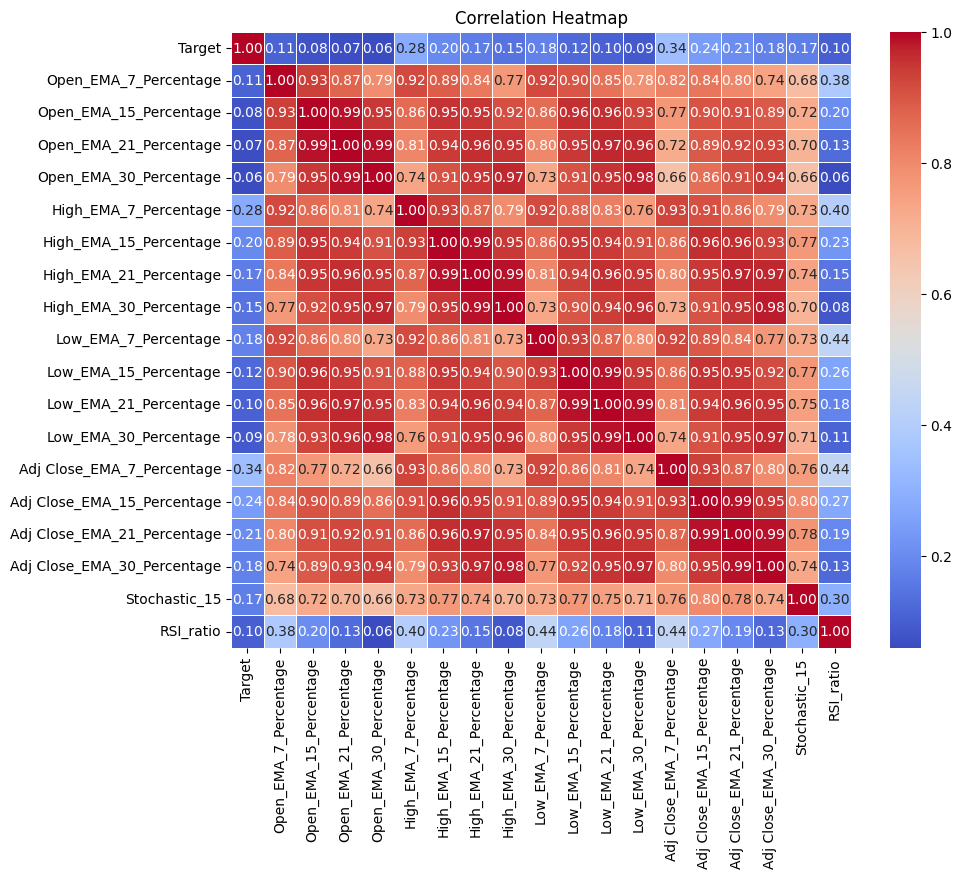

In [37]:
correlation_matrix = df_filled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [38]:
corr_matrix = df_filled.corr().abs()

C:\Users\02485986\AppData\Local\Temp\ipykernel_47444\1897262672.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_filled.corr().abs()


In [39]:
corr_matrix.sort_values(by='Target', ascending=False)['Target']

Target                         1.000000
Adj Close_EMA_7_Percentage     0.341941
High_EMA_7_Percentage          0.282989
Adj Close_EMA_15_Percentage    0.240245
Adj Close_EMA_21_Percentage    0.205416
High_EMA_15_Percentage         0.197356
Low_EMA_7_Percentage           0.180360
Adj Close_EMA_30_Percentage    0.178339
Stochastic_15                  0.171599
High_EMA_21_Percentage         0.169029
High_EMA_30_Percentage         0.147931
Low_EMA_15_Percentage          0.122864
Open_EMA_7_Percentage          0.110420
Low_EMA_21_Percentage          0.104634
RSI_ratio                      0.102452
Low_EMA_30_Percentage          0.092512
Open_EMA_15_Percentage         0.075489
Open_EMA_21_Percentage         0.065368
Open_EMA_30_Percentage         0.060395
Name: Target, dtype: float64

In [40]:
def get_highly_correlated_pairs(data, threshold=0.95):

    """
    We will use the first half of the data to identify correlated features and remove the less important ones. 
    To determine feature importance, we will employ the Logistic Regression.Next, we will compute the correlation 
    matrix and focus on the upper triangle to find pairs of features with correlations exceeding a specified threshold. 
    We will then construct a DataFrame to capture the feature importances as assessed by the Logistic Regression.
    Additionally, we will create another DataFrame to document the correlated feature pairs along with their respective importances.
    """

    data_sorted = data.sort_values('Date')
    data_first_half_train = data_sorted.iloc[:len(data_sorted) // 2]

    X_train = data_first_half_train.drop(['Target', 'Date'], axis=1)
    y_train = data_first_half_train['Target']

    # Correlation matrix
    corr_matrix = X_train.corr().abs()

    # Upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Pairs with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    correlated_pairs = [(i, j) for i in to_drop for j in upper.columns if upper.loc[i, j] > threshold]

    lr = LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced')
    lr.fit(X_train, y_train)

    # The absolute values of the coefficients as feature importance
    feature_importances = abs(lr.coef_[0])
    df_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    df_correlated_pairs_importance = pd.DataFrame([(pair[0], pair[1], df_feature_importance.loc[df_feature_importance['Feature'] == pair[0], 'Importance'].values[0], df_feature_importance.loc[df_feature_importance['Feature'] == pair[1], 'Importance'].values[0]) for pair in correlated_pairs], columns=['Feature_1', 'Feature_2', 'Importance_1', 'Importance_2'])

    # Calculate the difference in importance between the two features in each pair
    df_correlated_pairs_importance['Importance_Difference'] = abs(df_correlated_pairs_importance['Importance_1'] - df_correlated_pairs_importance['Importance_2'])

    # Determine the feature with the lower importance to drop
    df_correlated_pairs_importance['Smaller_Importance_Feature'] = df_correlated_pairs_importance.apply(lambda row: row['Feature_1'] if row['Importance_1'] < row['Importance_2'] else row['Feature_2'], axis=1)

    # Sort the DataFrame by the difference in importance
    df_correlated_pairs_importance = df_correlated_pairs_importance.sort_values(by='Importance_Difference', ascending=False)
    
    return df_correlated_pairs_importance

In [41]:
pd.set_option('display.max_rows', None)
correlated_pairs_df = get_highly_correlated_pairs(df_filled, threshold=0.95)
correlated_pairs_df['Smaller_Importance_Feature'].unique()

array(['High_EMA_30_Percentage', 'Low_EMA_21_Percentage',
       'Low_EMA_30_Percentage', 'High_EMA_21_Percentage',
       'Adj Close_EMA_21_Percentage', 'Adj Close_EMA_30_Percentage',
       'Open_EMA_21_Percentage'], dtype=object)

In [42]:
correlated_pairs_df.head()

,Feature_1,Feature_2,Importance_1,Importance_2,Importance_Difference,Smaller_Importance_Feature
3,Open_EMA_30_Percentage,High_EMA_30_Percentage,4.057429,0.330690,3.726739,High_EMA_30_Percentage
1,Open_EMA_21_Percentage,Low_EMA_21_Percentage,4.013024,0.609978,3.403046,Low_EMA_21_Percentage
4,Open_EMA_30_Percentage,Low_EMA_30_Percentage,4.057429,0.867436,3.189994,Low_EMA_30_Percentage
2,Open_EMA_21_Percentage,Low_EMA_30_Percentage,4.013024,0.867436,3.145588,Low_EMA_30_Percentage
6,High_EMA_21_Percentage,Adj Close_EMA_21_Percentage,0.386047,3.109115,2.723069,High_EMA_21_Percentage


In [43]:
"""
There are some features that are highly correlated with each other. We will drop one of the features in each pair to reduce multicollinearity.
The features to drop are selected based on the feature importance values from a Logistic Regression.
"""
df_filled.drop(columns = correlated_pairs_df['Smaller_Importance_Feature'].unique(), inplace = True)	

# 5. Modelling

In [44]:
df_filled.head()

,Date,Target,Open_EMA_7_Percentage,Open_EMA_15_Percentage,Open_EMA_30_Percentage,High_EMA_7_Percentage,High_EMA_15_Percentage,Low_EMA_7_Percentage,Low_EMA_15_Percentage,Adj Close_EMA_7_Percentage,Adj Close_EMA_15_Percentage,Stochastic_15,RSI_ratio
0,2010-06-29,0,-2.631579e-09,-2.631579e-09,-2.631579e-09,-2.000000e-09,-2.000000e-09,-2.850627e-09,-2.850627e-09,-2.092926e-09,-2.092926e-09,34.455959,1.410949
1,2010-06-30,0,1.974603e-01,2.303703e-01,2.462945e-01,1.336292e-01,1.559007e-01,1.854077e-01,2.163090e-01,-1.888378e-03,-2.203107e-03,34.455959,1.410949
2,2010-07-01,0,1.290750e-01,1.802937e-01,2.081240e-01,-1.258681e-02,8.186244e-03,4.773063e-02,8.676615e-02,-6.540301e-02,-7.660235e-02,34.455959,1.410949
3,2010-07-02,0,4.000679e-02,9.538808e-02,1.302804e-01,-1.021510e-01,-9.878078e-02,-2.375067e-02,9.294826e-03,-1.639160e-01,-2.024434e-01,34.455959,1.410949
4,2010-07-06,0,-7.799414e-02,-3.526575e-02,-1.660854e-04,-2.047383e-01,-2.354553e-01,-1.575036e-01,-1.495788e-01,-2.903719e-01,-3.789447e-01,34.455959,1.410949


### 5.1.Random Search Cross Validation with TimeSeriesSplit

In [51]:
def Model_Tries(data):

    data_sorted = data.sort_values('Date')
    X = data_sorted.drop(['Target', 'Date'], axis=1)
    y = data_sorted['Target']

    split_index = int(len(data) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Calculate the scale_pos_weight parameter for the XGBoost model to solve the class imbalance problem
    neg_class = sum(y_train == 0)
    pos_class = sum(y_train == 1)
    scale_pos_weight = neg_class / pos_class

    model_list = [
    ('XGB', XGBClassifier(scale_pos_weight = scale_pos_weight)),
    ('KNN', KNeighborsClassifier(weights='distance')),
    ('RF', RandomForestClassifier(n_estimators=1000, criterion='gini',class_weight='balanced_subsample')),
    ('LR', LogisticRegression(solver='liblinear',class_weight='balanced')) 
    ]

    param_grids = {
    'XGB': {
        'max_depth': [3, 4,5],
        'learning_rate': [0.01,0.05, 0.1],
        'subsample': np.arange(0.6, 0.9, 0.1),
        'colsample_bytree': np.arange(0.4, 0.8, 0.1),
        'colsample_bylevel': np.arange(0.4, 0.8, 0.1),
        'n_estimators': [100,200, 500],
        'reg_alpha':  [0.1, 0.5, 1], 'reg_lambda':  [0.1, 0.5, 1], 'min_child_weight': [1, 3, 5], 
    'gamma': [0, 0.1, 0.2]
    },
    'KNN': {
        'n_neighbors': [5, 10, 15, 20],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'RF': {
        'max_depth': [10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [100, 500, 1000]
    },
    'LR':{'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] 
    }
    }

    tscv = TimeSeriesSplit(n_splits=5,gap = 20)

    best_models = {}
    results_list = [] 

    for name, model in model_list:
        params = param_grids[name]
        clf = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=100,
            cv=tscv,
            n_jobs=-1,
            scoring='roc_auc',
            refit=True,
            return_train_score=True
        )

        clf.fit(X_train, y_train)
        best_models[name] = clf.best_estimator_

    for name, best_model in best_models.items():
        cv_results = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
        y_test_pred = best_model.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test, y_test_pred)
        results_list.append({'Model': name, 'CV ROC AUC Mean': cv_results.mean(), 'CV ROC AUC Std': cv_results.std(), 'Test ROC AUC Score': test_score})

    results_df = pd.DataFrame(results_list) 
    print(results_df)
    return(best_models)
            

In [52]:
best_models = Model_Tries(df_filled)

C:\Users\02485986\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\02485986\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
155 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\02485986\AppData\Local\

  Model  CV ROC AUC Mean  CV ROC AUC Std  Test ROC AUC Score
0   XGB         0.971638        0.017010            0.942203
1   KNN         0.706804        0.104272            0.728748
2    RF         0.973596        0.021784            0.942626
3    LR         0.985516        0.006353            0.947919


C:\Users\02485986\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 5.2.Model Decision : Logistic Regression

In [53]:
chosen_model = best_models['LR']

In [54]:
chosen_model

LogisticRegression(C=3792.690190732246, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [50]:
"""
Based on the model performance, we can say that the Logistic Regression model is the best model for this dataset.
It has best train and test scores. Plus, the standard deviation of cross validation scores is the lowest among the models.

"""
data_sorted = df_filled.sort_values('Date')
X = data_sorted.drop(['Target', 'Date'], axis=1)
y = data_sorted['Target']

split_index = int(len(df_filled) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

chosen_model.fit(X_train, y_train)
y_pred_proba = chosen_model.predict_proba(X_test)
y_pred_true_label = y_pred_proba[:, 1]
y_pred_all_labels = np.argmax(y_pred_proba, axis=1)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_true_label)

test_score = roc_auc_score(y_test, y_pred_true_label)
print('ROC AUC Score for Test Data:',test_score)


ROC AUC Score for Test Data: 0.9492231512779458


C:\Users\02485986\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### 5.2.1. ROC Curve

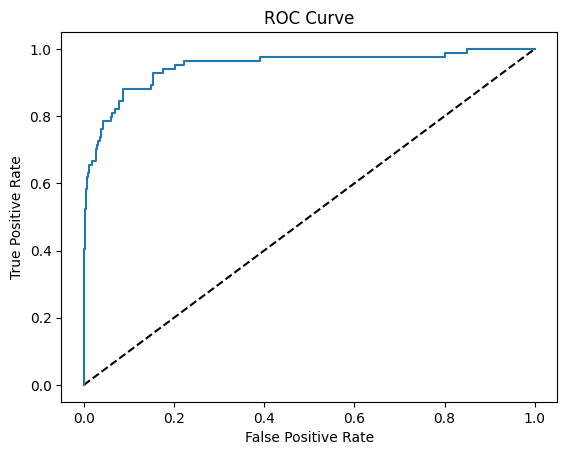

In [51]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### 5.2.2. Confusion Matrix

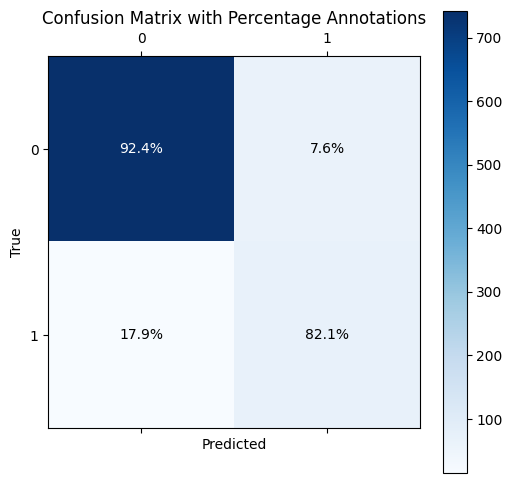

In [52]:
# Normalize the confusion matrix for displaying percentages
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_all_labels)
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confusion_matrix, cmap='Blues')

# Loop over data dimensions and create text annotations for percentages only.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        percentage = f"{cm_normalized[i, j]*100:.1f}%"
        ax.text(j, i, percentage, ha="center", va="center", 
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")

plt.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Percentage Annotations')
plt.show()

#### 5.2.3. Feature Importance based on Coefficients 

In [53]:
feature_names = X_test.columns
coefficients = chosen_model.coef_[0]  # For logistic regression, coef_ is a 2D array

# Creating a DataFrame from the coefficients with their absolute values
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(coefficients)})

# Sorting the DataFrame by the 'Coefficient' column in descending order
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

# Displaying the sorted DataFrame
coef_df_sorted

,Feature,Coefficient
7,Adj Close_EMA_7_Percentage,674.086821
0,Open_EMA_7_Percentage,486.335581
1,Open_EMA_15_Percentage,373.815714
8,Adj Close_EMA_15_Percentage,352.153162
6,Low_EMA_15_Percentage,259.425069
5,Low_EMA_7_Percentage,220.334863
4,High_EMA_15_Percentage,105.184232
3,High_EMA_7_Percentage,95.221956
10,RSI_ratio,2.083242
2,Open_EMA_30_Percentage,1.727914


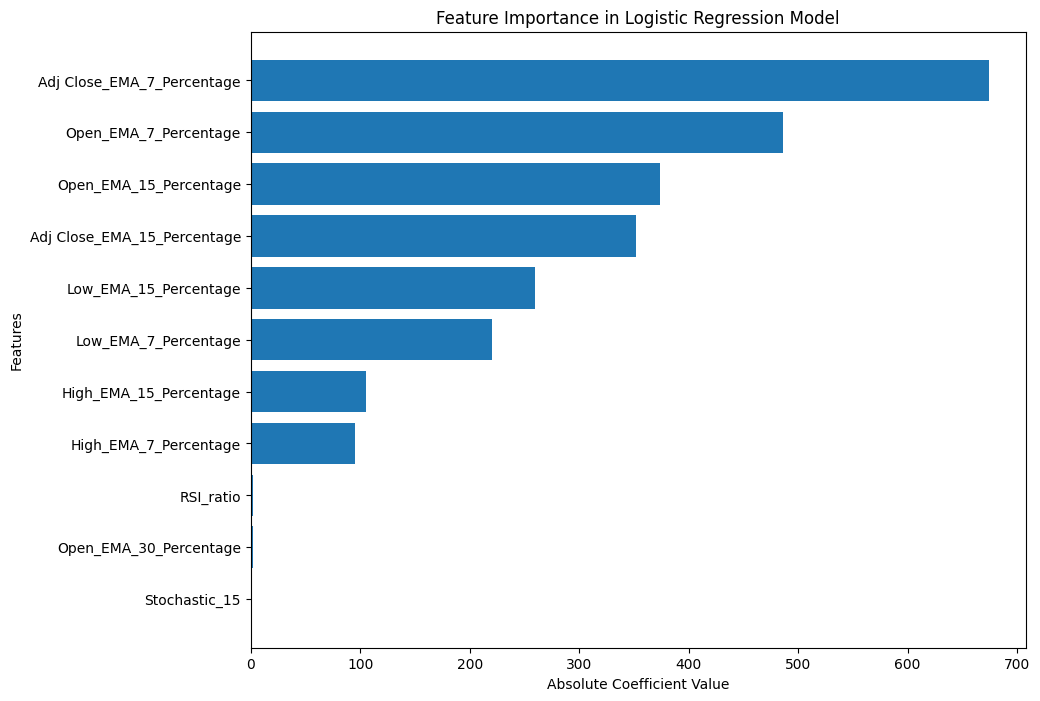

In [54]:
plt.figure(figsize=(10, 8))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance in Logistic Regression Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()